# Tarea 3
## MA5203 - Aprendizaje de Máquinas Probabilístico
### Sebastián Parra

In [ ]:
#Importar Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

In [ ]:
# Configuracion graficos
sns.set()  
sns.set_context('notebook', rc={"lines.linewidth": 2.5})
sns.set_style('white')
plt.rcParams['figure.figsize'] = (15, 7)

In [ ]:
#Funciones importantes

## leerDatos: Lee los datos de un archivo .txt y devuelve sus coordenadas en R^2 y sus clases como arrays de numpy
## (se asume que tiene 3 filas: posicion en X, posicion en Y, y Clase)
## input: 
##     filepath - (string) String que indique la ubicacion del archivo
## outputs:
##     X - (array) Matriz de coordenadas R^2 del punto (la primera y segunda fila de datos)
##     Y - (array) El vector de clases (la tercera fila de datos)
def leerDatos(filepath):
    #Guardar archivo .txt en dataframe (se asume que los valores están separados por espacios y no tienen header)
    df = pd.read_csv(filepath, header=None)
    
    X = df.values[:2,:] #Obtener matriz de cordenadas
    Y = df.values[2,:] #Obtener vector de clases
    return X, Y

## graficarDatos: Grafica los datos etiquetando su clase respectiva
## input: 
##      X - (array) Matriz de cordenadas
##      Y - (array) Vector de clases
def graficarDatos(X, Y):
    c0 = X[:,Y == 0] #Cordenada X de los puntos clase 0
    c1 = X[:,Y == 1] #Cordenada X de los puntos clase 1
    
    plt.scatter(c0[0,:], c0[1,:], s = 5, c = 'r', label='Clase 0')
    plt.scatter(c1[0,:], c1[1,:], s = 5, c = 'b', label='Clase 1')
    plt.xlabel("Cordenada X")
    plt.ylabel("Cordenada Y")
    plt.title("Gráfico Datos Tarea 3")
    plt.legend()
    plt.show()

## sigmoide: Retorna la funcion sigmoide evaluada en w @ x
## input:  
##      w - (array) Vector de parametros del modelo
##      x - (array) Matriz de datos    
def sigmoide(w, x):
    argumento = w[1:] @ x.T + w[0] 
    return 1 / (1 + np.exp(-argumento))

## NLL: Retorna la log-verosimilitud negativa para el vector de parametros w, la matriz de datos x, el vector
## de clases y, y el coeficiente de regulacion rho.
## input:  
##      w - (array) Vector de parametros del modelo
##      x - (array) Matriz de datos   
##      y - (array) Vector de clases
##      rho - (float) Coeficiente de regulacion
def NLL(w, x, y, rho=0.1):
    #Calcular sumatoria
    nll1 = (y * np.log(sigmoide(w,x)) + (1 - y) * np.log(1 - sigmoide(w,x)) ).sum()
    #Calcular resto de la ecuacion
    nll2 = rho * (w**2).sum()
    return -(nll1 + nll2)

## metropolisHastings: Retorna un vector de muestras de la distribucion posterior del problema, a partir de los
## inputs introducidos.
## input:  
##      datos - (array) Matriz de datos del modelo
##      clases - (array) Vector de clases de los datos   
##      it - (int) Numero de iteraciones a realizar
##      valorInicial - (array) Vector de adivinanza inicial de los parametros
##      paso - (float) Ancho de la distribucion normal de la cual extraer valores propuestos
##      funcionPrior - (funcion, por defecto None) Funcion densidad de probabilidad del prior. Si no se especifica
##      se asume prior no informativo
##      param1Prior, param2Prior - (float) Parametros a introducir a la funcion densidad de pobabilidad del prior 
def metropolisHastings(datos, clases, it, valorInicial, paso, funcionPrior=None, param1Prior=0, param2Prior=0):
    #Inicializar variable para calcular grado de aceptabilidad
    aceptados = 0
    
    #Inicializar matriz de muestras
    muestras = np.array([valorInicial])
   
    
    for i in range(it):
        #Calcular log-verosimilitud iteracion anterior
        valorOld = muestras[len(muestras)-1]
        logVerosimOld = NLL(valorOld, datos, clases) * (-1)
        probOld = np.exp(logVerosimOld)
        
        #Proponer nuevos parametros a partir de distribucion gaussiana y calcular nueva log-verosimilitud
        valorNuevo = np.zeros([len(valorOld)])
        for j in range(len(valorOld)):
            valorNuevo[j] = stats.norm(valorOld[j], paso).rvs()
        logVerosimNuevo = NLL(valorNuevo, datos, clases) * (-1)
        probNuevo = np.exp(logVerosimNuevo)
        
        #Si prior NO ES no informativo, calcularlo
        if funcionPrior != None:
            priorOld = funcionPrior(param1Prior, param2Prior).pdf(valorOld)
            priorNuevo = funcionPrior(param1Prior, param2Prior).pdf(valorNuevo)
            
            probOld = np.sum(np.exp(logVerosimOld)*priorOld)
            probNuevo = np.sum(np.exp(logVerosimNuevo)*priorNuevo)
        
        #Determinar si se aceptan o no los nuevos parametros propuestos
        if probNuevo > probOld: #Aceptar muestra siempre
            muestras = np.append(muestras, np.array([valorNuevo]), axis=0)
            aceptados += 1
        else: #Aceptar muestra con cierta probabilidad
            random = np.random.rand()
            if random < (probNuevo / probOld):
                muestras = np.append(muestras, np.array([valorNuevo]), axis=0)
                aceptados += 1
            else:
                muestras = np.append(muestras, np.array([valorOld]), axis=0)
    print("Porcentaje de aceptados: " + str(aceptados/it))
    return muestras

## limpiarMuestras: Limpia el vector de muestras obtenidas por metropolis hastings para reducir la autocorrelacion.
## input:  
##      muestras - (array) Vector de muestras
##      iteraciones - (int) Numero de iteraciones realizadas con Metropolis-Hastings  
def limpiarMuestras(muestras, iteraciones):
    #Tomar la segunda mitad de las muestras
    aux = muestras[int(iteraciones/2):,:]
    
    #De este subconjunto, solo tomar cada 10 valores
    limpias = np.array([aux[0,:]])
    for i in range(len(aux)-1):
        if (i+1)%10 == 0:
            limpias = np.append(limpias, np.array([aux[i,:]]), axis=0)
    return limpias

In [ ]:
############################################
# Parte 1: Cargar los datos y visualizarlos
############################################

#Variable con el filepath al archivo con los datos. Por defecto se asume que el archivo esta en la misma carpeta
#que el .ipynb
filepath = 'datosT3_.txt'
datosX, datosY = leerDatos(filepath)

graficarDatos(datosX, datosY)

In [ ]:
####################################################
# Parte 2: Regresión Logística con log-verosimilitud
####################################################

#Obtener conjuntos de entrenamiento y de prueba
xTrain, xTest, yTrain, yTest = train_test_split(datosX.T, datosY.T, test_size=0.25)

#Establecer condicion inicial
condInicial = np.zeros(xTrain.shape[1] + 1)

#Argumentos que no se desea optimizar
argumentos = (xTrain, yTrain, 0.1)

#Optimizar log-verosimilitud negativa
opt = minimize(NLL, condInicial, argumentos, 'L-BFGS-B', jac=False, tol=1e-12,
               options={'disp': True, 'maxiter': 1000})

wOptimo = opt.x

#Graficar recta
rectaX = np.linspace(np.floor(np.min(datosX)), np.ceil(np.max(datosX)), 100)
rectaY = -wOptimo[1] / wOptimo[2] * rectaX - wOptimo[0] / wOptimo[2]

plt.plot(rectaX, rectaY, label='Hiperplano separador NLL', c='black')
graficarDatos(datosX, datosY)

In [ ]:
######################################################
# Parte 3: Regresión Logística con Metropolis-Hastings
######################################################

#Generar vector de valores de inicialización (en este caso, se usa el valor obtenido en la parte anterior)
valInicial = wOptimo

#Definir numero de iteraciones
iteraciones = 20000

#Definir magnitud del paso entre adivinanzas
paso = 0.1

#Aplicar metropolis hastings para distintos priors posibles
noInformativo = metropolisHastings(datosX.T, datosY.T, iteraciones, valInicial, paso)
priorNormal = metropolisHastings(datosX.T, datosY.T, iteraciones, valInicial, paso, funcionPrior=stats.norm,
                                param1Prior=0, param2Prior=2)
priorUniforme = metropolisHastings(datosX.T, datosY.T, iteraciones, valInicial, paso, funcionPrior=stats.uniform,
                                param1Prior=-2, param2Prior=4)

In [ ]:
########################################
# Parte 4: Visualizaciones de resultados
########################################

#Limpiar muestras para reducir autocorrelación
limpiasNI = limpiarMuestras(noInformativo, iteraciones)
limpiasNormal = limpiarMuestras(priorNormal, iteraciones)
limpiasUniforme = limpiarMuestras(priorUniforme, iteraciones)
        
#Obtener promedios y graficar rectas
promNI = np.mean(limpiasNI, axis=0)
promNormal = np.mean(limpiasNI, axis=0)
promUniforme = np.mean(limpiasUniforme, axis=0)

rectaX = np.linspace(np.floor(np.min(datosX)), np.ceil(np.max(datosX)), 100)

rectaNI = -promNI[1] / promNI[2] * rectaX - promNI[0] / promNI[2]
rectaNormal = -promNormal[1] / promNormal[2] * rectaX - promNormal[0] / promNormal[2]
rectaUniforme = -promUniforme[1] / promUniforme[2] * rectaX - promUniforme[0] / promUniforme[2]

plt.plot(rectaX, rectaY, label='Hiperplano separador NLL', c='black')
plt.plot(rectaX, rectaNI, label='Hiperplano separador M-H con prior no informativo', c='green', linestyle='dashdot')
plt.plot(rectaX, rectaY, label='Hiperplano separador M-H con prior gaussiano (0,2)', c='magenta', linestyle='dashed')
plt.plot(rectaX, rectaY, label='Hiperplano separador M-H con prior uniforme (-2,2)', c='cyan', linestyle='dotted')
graficarDatos(datosX, datosY)

In [ ]:
#Graficar histogramas
plt.hist(limpiasNormal[:,0], 30)
plt.xlabel('w[0]')
plt.ylabel('frecuencia')
plt.title('Histograma de las muestras obtenidas para w[0] (parametro afin)')
plt.show()

plt.hist(limpiasNormal[:,1], 30)
plt.xlabel('w[1]')
plt.ylabel('frecuencia')
plt.title('Histograma de las muestras obtenidas para w[1] (parametro ponderado por la cordenada X)')
plt.show()

plt.hist(limpiasNormal[:,2], 30)
plt.xlabel('w[2]')
plt.ylabel('frecuencia')
plt.title('Histograma de las muestras obtenidas para w[2] (parametro ponderado por la cordenada Y)')
plt.show()

#Calcular modas
modas = stats.mode(limpiasNormal)[0]
print("Modas M-H: [" + str(modas[0,0]) + " " + str(modas[0,1]) + " " + str(modas[0,2]) + "]")
print("Parametros NLL: [" + str(wOptimo[0]) + " " + str(wOptimo[1]) + " " + str(wOptimo[2]) + "]")

In [5]:
#############################
# Parte 5: Proyecto del Curso
#############################
#Integrantes del grupo: Vicente Peña, Ignacio, y Sebastián Parra

#Tema del proyecto: Clasificacion de kanjis manuscritos

#El problema consiste en desarrollar un clasificador que permita distinguir distintos carácteres de kanji
#(uno de los alfabetos japoneses caracterizado por la complejidad y similitud entre sus carácteres) a partir
#de imagenes con símbolos manuscritos (smilar al clásico MNIST). La base de datos a utilizar se conoce como ETL- 8 
#y se puede encontrar en http://etlcdb.db.aist.go.jp/. Ésta consiste en 140480 imágenes de 878 diferentes kanjis
#más 12.000 imágnes de 75 letras distintas del alfabeto hiragana. Cada imagen es de 64 x 64 píxeles

import struct
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

sz_record = 8199


def read_record_ETL8G(f):
    s = f.read(sz_record)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)


def read_kanji():
    ary = np.zeros([72, 160, 127, 128], dtype=np.uint8)

    for j in range(1, 33):
        filename = '../Proyecto/ETL8G/ETL8G_{:02d}'.format(j)
        with open(filename, 'rb') as f:
            for id_dataset in range(5):
                moji = 0
                for i in range(956):
                    r = read_record_ETL8G(f)
                    if b'.KAN' in r[2]:
                        ary[moji, (j - 1) * 5 + id_dataset] = np.array(r[-1])
                        moji += 1
    np.savez_compressed("kanji.npz", ary)

read_kanji()

#Generar vector de imagenes
imagenes = np.load("kanji.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

In [26]:
#Eliminar imagenes vacias
imagenes_no_vacias = np.array([imagenes[0]])
for i in range(len(imagenes)-1):
    maximo = np.max(imagenes[i+1])
    if maximo > 0:
        imagenes_no_vacias = np.append(imagenes_no_vacias, np.array([imagenes[i+1]]), axis=0)

(960, 127, 128)


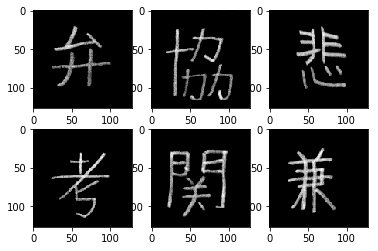

In [31]:
#Ver dimensiones del vector de imagenes no vacias
print(imagenes_no_vacias.shape)

##Visualizar una imagen aleatoria
#plt.imshow(imagenes_no_vacias[np.random.randint(0,len(imagenes_no_vacias))], cmap='gray')
#plt.show()

#Como en la página del dataset se especifica que son 160 imagenes por clase
n_clases = 960/160
imagenes_labels = np.repeat(np.arange(n_clases), 160)

#Visualizar clases
plt.subplot(2,3,1)
plt.imshow(imagenes_no_vacias[0], cmap='gray')
plt.subplot(2,3,2)
plt.imshow(imagenes_no_vacias[160], cmap='gray')
plt.subplot(2,3,3)
plt.imshow(imagenes_no_vacias[160*2], cmap='gray')
plt.subplot(2,3,4)
plt.imshow(imagenes_no_vacias[160*3], cmap='gray')
plt.subplot(2,3,5)
plt.imshow(imagenes_no_vacias[160*4], cmap='gray')
plt.subplot(2,3,6)
plt.imshow(imagenes_no_vacias[160*5], cmap='gray')
plt.show()

In [24]:
# Tarea 4: Implementación de clasificación con random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

imagenes_no_vacias = imagenes_no_vacias.reshape([960, -1])
img_train, img_test, label_train, label_test = train_test_split(imagenes_no_vacias, imagenes_labels, test_size=0.2)

clf = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1)

clf.fit(img_train, label_train)
clf.score(img_test, label_test)

0.921875